In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class GaussianClass:
    def __init__(self, train_size, test_size, dim, center, std):
        self.Xtr = np.array([np.random.normal(loc=center, scale=std, size=dim) for _ in range(train_size)])
        self.Xte = np.array([np.random.normal(loc=center, scale=std, size=dim) for _ in range(test_size)])
        self.Xtr_enc = None
        self.Xte_enc = None
        
    def encode(self, encoder):
        self.Xtr_enc = encoder.encode_list(self.Xtr)
        self.Xte_enc = encoder.encode_list(self.Xte)


class Dataset:
    def __init__(self, classes):
        self.classes = classes   
    
    def get_class_hypervectors(self, encoder, agg="bundle", threshold=500):
        for cls in self.classes:
            cls.encode(encoder)
        
        if agg == "bundle":
            class_hvs = [np.sum(cls.Xtr_enc, axis=0) for cls in self.classes]
        elif agg == "retrain":
            class_hvs = [np.sum(cls.Xtr_enc, axis=0) for cls in self.classes]
            
            for _ in range(threshold):
                perfect = True
                for i, cls in enumerate(self.classes):
                    for phi_x in cls.Xtr_enc:
                        sims = [encoder.sim(phi_x, phi_c) for phi_c in class_hvs]
                        pred_cls = np.argmax(sims)
                        if i != pred_cls:
                            class_hvs[i] += (1 - sims[i]) * phi_x
                            class_hvs[pred_cls] -= sims[pred_cls] * phi_x
                            perfect = False
                if perfect: break
        
        return class_hvs
    
class Encoder:
    def encode(self, x):
        raise NotImplementedError
    
    def encode_list(self, X):
        encoded_hvs = []
        for x in X:
            encoded_hvs.append(self.encode(x))
        return np.array(encoded_hvs)
    
    def get_lipschitz_constant(self, out=True):
        raise NotImplementedError

    def inner(self, x, y):
        raise NotImplementedError
        
    def sim(self, x, y):
        inner = self.inner(x, y)
        norm = np.sqrt(self.inner(x, x) * self.inner(y, y))
        return inner if inner == 0 else inner / norm
        
    def plot_kernel(self):
        xs = np.linspace(-10, 10, num=1000)
        xs_enc = self.encode_list(xs)
        phi_0 = self.encode(0).reshape(-1)
        sims = [self.inner(phi_0, x) for x in xs_enc]
        plt.plot(xs, sims)

class FHRREncoder(Encoder):
    def __init__(self, in_dim, out_dim, kernel="rbf"):
        super().__init__()
        
        if kernel == 'rbf':
            self.M = np.random.normal(size=(out_dim, in_dim))
        elif kernel == 'sinc':
            self.M = np.random.rand(out_dim, in_dim)
        elif kernel == 'laplace':
            self.M = np.random.laplace(size=(out_dim, in_dim))
        else:
            self.M = np.random.beta(10, 10, size=(out_dim, in_dim))
        
    def encode(self, x):
        return np.exp(1j * self.M.dot(x))
    
    def get_lipschitz_constant(self, out=False):
        def get_beta(x, phi_x, phi_0, D):
            return np.sqrt(2 * (D - self.inner(phi_x, phi_0))) / np.abs(x)
        
        xs = np.linspace(-10, 10, num=1000)
        xs_enc = encoder.encode_list(xs)
        phi_0 = encoder.encode(0).reshape(-1)
        betas = [get_beta(xs[i], xs_enc[i].reshape(-1), phi_0, out_dim) for i in range(len(xs))]
        
        if out:
            plt.plot(xs, betas)

        bs = []
        for x in [10**(-i) for i in range(0, 10)]:
            phi_x = encoder.encode(x).reshape(-1)
            beta = get_beta(x, phi_x, phi_0, out_dim)
            bs.append(beta)
            if out:
                print(beta)
        beta = np.max(bs)
        return beta
    
    def get_lipschitz_constant2(self, phi_c1, phi_c2):
        v = phi_c1 - phi_c2
        xs = np.linspace(-10, 20, 10000)
        def f(x):
            Mx = self.M.dot(x).reshape(-1)
            z = -v.real * np.sin(Mx) + v.imag * np.cos(Mx)
            return z.dot(self.M)
        sims = [f(x) for x in xs]
        #plt.plot(xs, sims)
        return np.max(np.abs(sims))
    
    def set_lipschitz_constant(self, phi_c1, phi_c2):
        phi_diff = phi_c1 - phi_c2
        self.L1 = np.sqrt(self.inner(phi_diff, phi_diff)) * self.get_lipschitz_constant()
        self.L2 = self.get_lipschitz_constant2(phi_c1, phi_c2)

    def inner(self, x, y):
        z = x.dot(np.conjugate(y))
        return z.real

In [3]:
def get_boundary_locs(qs, sims):
    boundary_locs = []
    for i in range(len(qs) - 1):
        if(sims[i] * sims[i+1] <= 0):
            boundary_locs.append(qs[i])
    return np.array(boundary_locs)

def get_eps(encoder, q, phi_c1, phi_c2, L):
    phi_diff = phi_c1 - phi_c2
    phi_q = encoder.encode(q).reshape(-1)
    r_q = encoder.inner(phi_diff, phi_q)
    return np.abs(r_q) / L
    
def plot_data(encoder, phi_c1, phi_c2, dataset):
    qs = np.linspace(-10, 20, num=1000)
    qs_enc = encoder.encode_list(qs)
    sims = np.array([encoder.inner(phi_q.reshape(-1), phi_c1 - phi_c2) for phi_q in qs_enc])
    
    L1 = encoder.L1
    L2 = encoder.L2
    boundary_locs = get_boundary_locs(qs, sims)
    
    X1 = dataset.classes[0].Xtr
    X2 = dataset.classes[1].Xtr
    
    # plot boundaries
    plt.figure()
    ax = plt.axes()
    ax.fill_between(qs, 0, 1, where=sims >= 0,
                    color='blue', alpha=0.3, transform=ax.get_xaxis_transform())
    ax.fill_between(qs, 0, 1, where=sims < 0,
                    color='red', alpha=0.3, transform=ax.get_xaxis_transform())
    ax.plot(qs, sims)
    ax.scatter(X1, np.zeros(len(X1)), color='blue')
    ax.scatter(X2, np.zeros(len(X2)), color='red')
    plt.show()
    
    # plot eps
    ds = []
    es1 = []
    es2 = []
    
    for i in range(len(qs)):
        q = qs[i]
        sim = sims[i]
        d = np.min(np.abs(boundary_locs - q))
        e1 = get_eps(encoder, q, phi_c1, phi_c2, L1)
        e2 = get_eps(encoder, q, phi_c1, phi_c2, L2)
        ds.append(d)
        es1.append(e1)
        es2.append(e2)
    
    plt.figure()
    plt.plot(qs, ds, label="Actual")
    plt.plot(qs, es2, label="Method 1")
    plt.plot(qs, es1, label="Method 2")
    plt.xlabel("x")
    plt.ylabel("ε")
    plt.legend()
    plt.show()

Computed Lipschitz constant using different methods. Smaller is better.
11577.854083766193
4624.940876563105


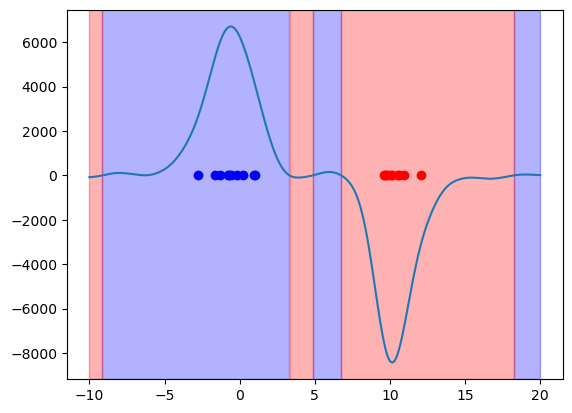

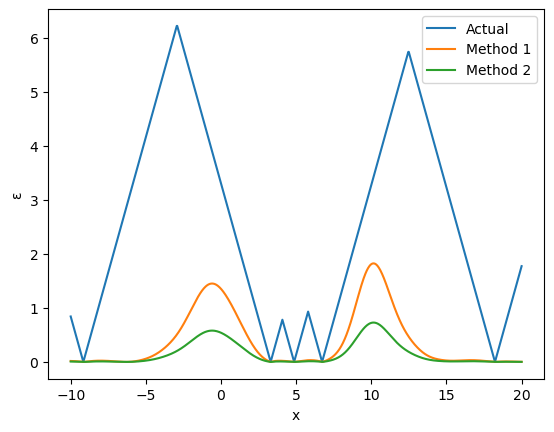

In [4]:
in_dim = 1
out_dim = 1000
train_size = 10
test_size = 10

c1 = GaussianClass(train_size, test_size, 1, 0, 1)
c2 = GaussianClass(train_size, test_size, 1, 10, 1)
dataset = Dataset([c1, c2])
encoder = FHRREncoder(in_dim, out_dim, kernel='rbf')
phis = dataset.get_class_hypervectors(encoder, agg='bundle')
phi_c1 = phis[0]
phi_c2 = phis[1]

encoder.set_lipschitz_constant(phi_c1, phi_c2)

print("Computed Lipschitz constant using different methods. Smaller is better.")
print(encoder.L1)
print(encoder.L2)

plot_data(encoder, phi_c1, phi_c2, dataset)

Computed Lipschitz constant using different methods. Smaller is better.
7389.561300442063
4263.998750413885


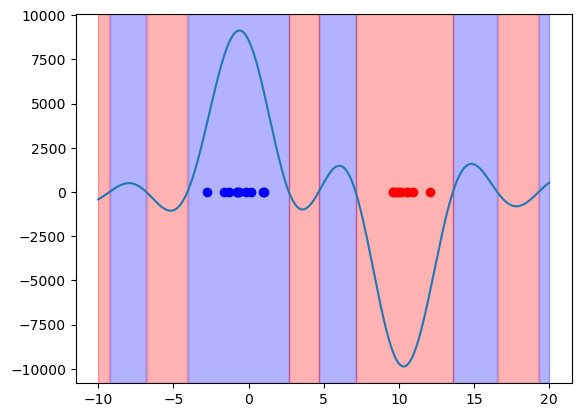

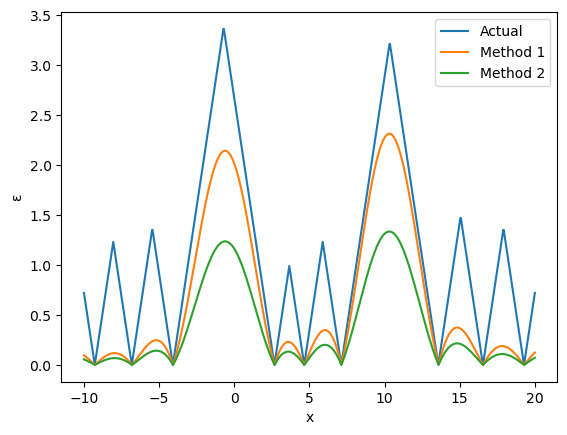

In [5]:
encoder = FHRREncoder(in_dim, out_dim, kernel='sinc')
phis = dataset.get_class_hypervectors(encoder, agg='bundle')
phi_c1 = phis[0]
phi_c2 = phis[1]

encoder.set_lipschitz_constant(phi_c1, phi_c2)

print("Computed Lipschitz constant using different methods. Smaller is better.")
print(encoder.L1)
print(encoder.L2)

plot_data(encoder, phi_c1, phi_c2, dataset)

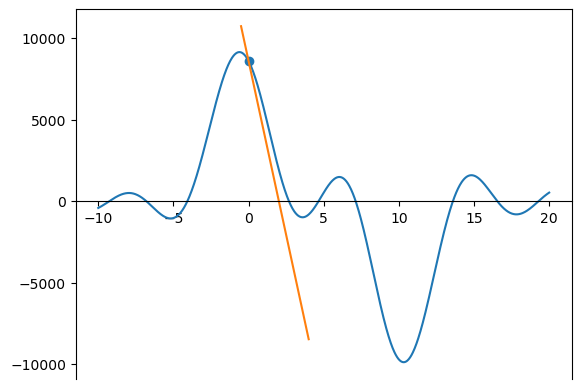

In [24]:
def plot_data(encoder, phi_c1, phi_c2, q):
    L = encoder.L2
    qs = np.linspace(-10, 20, num=1000)
    qs_enc = encoder.encode_list(qs)
    sims = np.array([encoder.inner(phi_q.reshape(-1), phi_c1 - phi_c2) for phi_q in qs_enc])
    
    q_enc = encoder.encode(q).reshape(-1)
    s = encoder.inner(q_enc, phi_c1 - phi_c2)
    
    xs = np.linspace(-0.5, 4, num=1000)
    ys = -L * xs + (s + q*L)
    
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.plot(qs, sims)
    ax.spines['bottom'].set_position('zero')
    ax.scatter(q, s)
    plt.plot(xs, ys)
    
plot_data(encoder, phi_c1, phi_c2, 0)